<a href="https://colab.research.google.com/github/mrunalmania/FinancialBot/blob/main/financial_RAG_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First we need to make the dictionary, where we can store the para as per the page number

In [ ]:
!pip install transformers==4.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.7 MB/s eta 0:00:00
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.7.0 requires transformers<5.0.0,>=4.34.0, but you have transformers 4.28.0 which is incompatible.


In [ ]:
!pip install PyMuPDF

In [ ]:

import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:


  cleaned_text = text.replace("\n", " ").strip()

  # potentially more text formatting can go here.
  return cleaned_text

# open the pdf document
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []

  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text)
    pages_and_texts.append({"page_number": page_number - 14, # because our main text of the book starts from the page number 15.
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(".")),
                            "page_token_count": len(text)/4,
                            "text": text})
  return pages_and_texts




In [ ]:
pdf_path = "The Intelligent Investor - The Definitive Book On Value Investing.pdf"
pages_and_texts = open_and_read_pdf(pdf_path)
print(f"[INFO] {len(pages_and_texts)} pages read.")
pages_and_texts[:2]


0it [00:00, ?it/s]

[INFO] 641 pages read.


[{'page_number': -14,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -13,
  'page_char_count': 154,
  'page_word_count': 46,
  'page_sentence_count_raw': 1,
  'page_token_count': 38.5,
  'text': 'THE  INTELLIGENT INVESTOR A B O O K  O F  P R A C T I C A L  C O U N S E L REVISED EDITION B E NJAM I N G RAHAM Updated with New Commentary by Jason Zweig'}]

In [ ]:
!pip install spacy

In [ ]:
from spacy.lang.en import English

# we need to add the senticizer pipeline which can effectively turn the text into sentences
nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("We have 2 cars. We want to purchase one more. We don't have enough money.")

assert len(list(doc.sents)) == 3

list(doc.sents)

[We have 2 cars., We want to purchase one more., We don't have enough money.]

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]
  item["sentences_count"] = len(item["sentences"])


  0%|          | 0/641 [00:00<?, ?it/s]

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 140,
  'page_char_count': 2365,
  'page_word_count': 405,
  'page_sentence_count_raw': 17,
  'page_token_count': 591.25,
  'text': 'New Common-Stock Offerings The following paragraphs are reproduced unchanged from the 1959 edition, with comment added: Common-stock financing takes two different forms. In the case of companies already listed, additional shares are offered pro rata to the existing stockholders. The subscription price is set below  the current market, and the “rights” to subscribe have an initial money value.* The sale of the new shares is almost always under- written by one or more investment banking houses, but it is the general hope and expectation that all the new shares will be taken by the exercise of the subscription rights. Thus the sale of addi- tional common stock of listed companies does not ordinarily call for active selling effort on the part of distributing firms. The second type is the placement with the public of common stock of what were f

In [ ]:
# Define split size to turn groups of sentences into chunks.
num_sentence_chunk_size = 10

# Creare a function to split the list of texts recursively into chunk size.
# e.g list of 20 -> [10,10], [25] -> [10,10,5]

def split_list(input_list: list[str],
               slice_size: int) -> list[list[str]]:
               return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list, 10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
# loop through pages and texts and split the sentences into chunks.
for item in tqdm(pages_and_texts):
  item["sentences_chunks"] = split_list(item["sentences"], num_sentence_chunk_size)

  item["num_chunks"] = len(item["sentences_chunks"])

  0%|          | 0/641 [00:00<?, ?it/s]

In [ ]:
import random

random.sample(pages_and_texts, k=1)

[{'page_number': 338,
  'page_char_count': 1531,
  'page_word_count': 255,
  'page_sentence_count_raw': 19,
  'page_token_count': 382.75,
  'text': 'COMMENTARY ON CHAPTER 13 In the Air Force we have a rule: check six. A guy is flying along, looking in all directions, and feeling very safe. Another guy flies up behind him (at “6 o’clock”—“12 o’clock” is directly in front) and shoots. Most airplanes are shot down that way. Thinking that you’re safe is very dangerous! Somewhere, there’s a weak- ness you’ve got to find. You must always check six o’clock. —U.S. Air Force Gen. Donald Kutyna E - B U S I N E S S As Graham did, let’s compare and contrast four stocks, using their reported numbers as of December 31, 1999—a time that will enable us to view some of the most drastic extremes of valuation ever recorded in the stock market. Emerson Electric Co. (ticker symbol: EMR) was founded in 1890 and is the only surviving member of Graham’s original quartet;  it makes a wide array of products, in

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentences_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/641 [00:00<?, ?it/s]

1203

In [ ]:
random.sample(pages_and_chunks, k=1)


[{'page_number': 121,
  'sentence_chunk': 'not mean that he is running a true risk of loss. If a group of well- selected common-stock investments shows a satisfactory overall return, as measured through a fair number of years, then this group investment has proved to be “safe.”During that period its market value is bound to fluctuate, and as likely as not it will sell for a while under the buyer’s cost. If that fact makes the investment “risky,” it would then have to be called both risky and safe at the same time. This confusion may be avoided if we apply the concept of risk solely to a loss of value which either is realized through actual sale, or is caused by a significant deterioration in the company’s position—or, more frequently perhaps, is the result of the payment of an excessive price in relation to the intrinsic worth of the security.2 Many common stocks do involve risks of such deterioration. But it is our thesis that a properly executed group investment in com- mon stocks do

In [ ]:
import pandas as pd
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1203.00,1203.00,1203.00,1203.00
mean,301.97,1073.87,179.99,268.47
std,179.38,516.31,84.29,129.08
min,-13.00,3.00,1.00,0.75
25%,146.50,729.00,121.00,182.25
50%,304.00,1087.00,184.00,271.75
75%,456.50,1400.00,237.00,350.00
max,626.00,2757.00,445.00,689.25


In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(n=5).iterrows():
    print(f"chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

chunk token count: 18.0 | Text: L 65b — a 1962 low was 371⁄ 2.b Adjusted for stock splits.def.:Net loss.
chunk token count: 0.75 | Text: 242
chunk token count: 2.5 | Text: 1007–1034.
chunk token count: 10.75 | Text: Tel.’s debt was less than its stock equity.
chunk token count: 2.0 | Text: deficit.


In [ ]:
# Filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_length[:2]

[{'page_number': -13,
  'sentence_chunk': 'THE INTELLIGENT INVESTOR A B O O K O F P R A C T I C A L C O U N S E L REVISED EDITION B E NJAM I N G RAHAM Updated with New Commentary by Jason Zweig',
  'chunk_char_count': 150,
  'chunk_word_count': 42,
  'chunk_token_count': 37.5},
 {'page_number': -10,
  'sentence_chunk': 'Contents Epigraph iii Preface to the Fourth Edition, by Warren E. Buffett A Note About Benjamin Graham, by Jason Zweig x Introduction: What This Book Expects to Accomplish 1 COMMENTARY ON THE INTRODUCTION 12 1. Investment versus Speculation: Results to Be Expected by the Intelligent Investor 18 COMMENTARY ON CHAPTER 1 35 2. The Investor and Inflation 47 COMMENTARY ON CHAPTER 2 58 3. A Century of Stock-Market History: The Level of Stock Prices in Early 1972 65 COMMENTARY ON CHAPTER 3 80 4. General Portfolio Policy: The Defensive Investor 88 COMMENTARY ON CHAPTER 4 101 5. The Defensive Investor and Common Stocks 112 COMMENTARY ON CHAPTER 5 124 6. Portfolio Policy for the 

In [ ]:
random.sample(pages_and_chunks_over_min_token_length, k=1)


[{'page_number': 415,
  'sentence_chunk': 'equally well to one invention or another—such as the following (in Bayard Taylor’s translation): Faust: Imagination in its highest flight Exerts itself but cannot grasp it quite. Mephistopheles (the inventor): If one needs coin the brokers ready stand. The Fool (finally): The magic paper . . . !416 The Intelligent Investor TABLE 16-4 Calculation of “True Market Price” and Adjusted Price/Earnings Ratio of a Common Stock with Large Amounts of Warrants Outstanding (Example: National General Corp. in June 1971) 1. Calculation of “True Market Price.”Market value of 3 issues of warrants, June 30, 1971 $94,000,000 Value of warrants per share of common stock $18.80 Price of common stock alone 24.50 Corrected price of common, adjusted for warrants 43.30 2. Calculation of P/E Ratio to Allow for Warrant Dilution Before After Warrant Dilution (1970 earnings) Warrant Company’s Our A. Before Special Items. Dilution Calculation Calculation Earned per share $

In [ ]:
!pip install sentence_transformers


  Using cached transformers-4.40.1-py3-none-any.whl (9.0 MB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0


In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-mpnet-base-v2",
                                      device="cpu")


# create a list of sentences
sentences = ["This framework generates embeddings for each input sentence",
             "Sentences are passed as a list of string.",
             "The quick brown fox jumps over the lazy dog."]

# sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# see the embeddings





In [ ]:
embeddings[0].shape

(768,)

In [ ]:
%%time
embedding_model.to("cpu")

# embed each chunk 1 by 1
for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1174 [00:00<?, ?it/s]

CPU times: user 15min 11s, sys: 22.1 s, total: 15min 33s
Wall time: 2min 37s


In [ ]:
%%time

text_chunks = [item["sentence_chunk"] for tem in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: user 93 µs, sys: 0 ns, total: 93 µs
Wall time: 96.1 µs


'About the Publisher Australia HarperCollins Publishers (Australia) Pty. Ltd. 25 Ryde Road (PO Box 321) Pymble, NSW 2073, Australia http://www.perfectbound.com.au Canada HarperCollins Publishers Ltd. 55 Avenue Road, Suite 2900 Toronto, ON, M5R, 3L2, Canada http://www.perfectbound.ca New Zealand HarperCollinsPublishers (New Zealand) Limited P . O. Box 1 Auckland, New Zealand http://www.harpercollins.co.nz United Kingdom HarperCollins Publishers Ltd. 77-85 Fulham Palace Road London, W6 8JB, UK http://www.uk.perfectbound.com United States HarperCollins Publishers Inc. 10 East 53rd Street New Y ork, NY 10022 http://www.perfectbound.com'

In [ ]:
len(text_chunks)

1174

In [ ]:
%%time

# Embed all texts in chunks
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=32, show_progress_bar=True, convert_to_tensor=True)
text_chunks_embeddings.shape

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

CPU times: user 7min 38s, sys: 1min 23s, total: 9min 2s
Wall time: 1min 32s


torch.Size([1174, 768])

In [ ]:
text_chunks_embeddings

tensor([[ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281],
        [ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281],
        [ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281],
        ...,
        [ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281],
        [ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281],
        [ 0.0538,  0.0407, -0.0143,  ..., -0.0055, -0.0145, -0.0281]])

In [ ]:
# we need to save the embeddings to the file. (If our pdf data is too large, then we should aim to use the vector searc database (e.g. MongoDB))

text_chunks_embedding_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
embeddings_df_save_path = "text_chunks_embeddings_df.csv"
text_chunks_embedding_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# Download the zipped FoodVision Mini app (if running in Google Colab)
# from google.colab import files
# files.download("text_chunks_embeddings_df.csv")

In [ ]:
# Import saved file and view.
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-13,THE INTELLIGENT INVESTOR A B O O K O F P R A C...,150,42,37.50,[-1.66591424e-02 5.78234112e-03 -1.48612289e-...
1,-10,Contents Epigraph iii Preface to the Fourth Ed...,903,149,225.75,[-1.17528411e-02 3.81936994e-03 -3.03675402e-...
2,-9,v Contents COMMENTARY ON CHAPTER 8 213 9. Inve...,735,121,183.75,[-5.40403323e-03 1.24255428e-02 -8.68558604e-...
3,-9,A Comparison of Eight Pairs of Companies 446 C...,355,54,88.75,[ 3.96490563e-03 -1.75390933e-02 -4.18122346e-...
4,-8,Contents vi 2. Important Rules Concerning Taxa...,974,155,243.50,[-6.81547495e-03 -2.00066753e-02 6.07826095e-...


In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util


device = "cuda" if torch.cuda.is_available() else "cpu"

# read embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_embeddings_df.csv")

# convert the embedding column back to the np array.
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert embeddings into torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert text and embedding df to list of dict
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-13,THE INTELLIGENT INVESTOR A B O O K O F P R A C...,150,42,37.50,"[-0.0166591424, 0.00578234112, -0.0148612289, ..."
1,-10,Contents Epigraph iii Preface to the Fourth Ed...,903,149,225.75,"[-0.0117528411, 0.00381936994, -0.0303675402, ..."
2,-9,v Contents COMMENTARY ON CHAPTER 8 213 9. Inve...,735,121,183.75,"[-0.00540403323, 0.0124255428, -0.00868558604,..."
3,-9,A Comparison of Eight Pairs of Companies 446 C...,355,54,88.75,"[0.00396490563, -0.0175390933, -0.00418122346,..."
4,-8,Contents vi 2. Important Rules Concerning Taxa...,974,155,243.50,"[-0.00681547495, -0.0200066753, 0.00607826095,..."


In [ ]:
# Create model
from sentence_transformers import SentenceTransformer, util

embedding_model = SentenceTransformer("all-mpnet-base-v2", device=device)


In [ ]:
# 1. Define the query string
query = "What is the market liquidity"

# 2. Encode the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get the similarity scores using the dot product, use cosine similarity if the output is not normalized.
dot_score = util.dot_score(query_embedding, embeddings)[0]

top_result_dot_product = torch.topk(dot_score, k=5)
top_result_dot_product

torch.return_types.topk(
values=tensor([0.6085, 0.4281, 0.4189, 0.4103, 0.4025], device='cuda:0'),
indices=tensor([400, 519, 517, 506, 602], device='cuda:0'))

In [ ]:
import textwrap
def print_wrapped(text, wrap_length:int = 80):
  wrapped_text = textwrap.fill(text, width=wrap_length)
  print(wrapped_text)
  return wrapped_text


In [ ]:
query = "What is the market liquidity"
print(f"Query: '{query}' \n")
print("Results:")

# loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_result_dot_product[0],top_result_dot_product[1]):
  print(f"Score: {score:.4f}")
  print(f"Text:")
  print(pages_and_chunks[idx]["sentence_chunk"])
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'What is the market liquidity' 

Results:
Score: 0.6085
Text:
But what this liquidity really means is, first, that the investor has the benefit of the stock market’s daily and changing appraisal of his holdings, for whatever that appraisal may be worth, and, second, that the investor is able to increase or decrease his investment at the market’s daily figure—if he chooses. Thus the existence of a quoted market gives the investor certain options that he does not have if his security is unquoted. But it does not impose the current quotation on an investor who prefers to take his idea of value from some other source. Let us close this section with something in the nature of a para- ble. Imagine that in some private business you own a small share that cost you $1,000. One of your partners, named Mr. Market, is 204 The Intelligent Investor
Page number: 203


Score: 0.4281
Text:
disregarded, as no longer called for, after the investor is sure that all the problems of stock-exchange fi

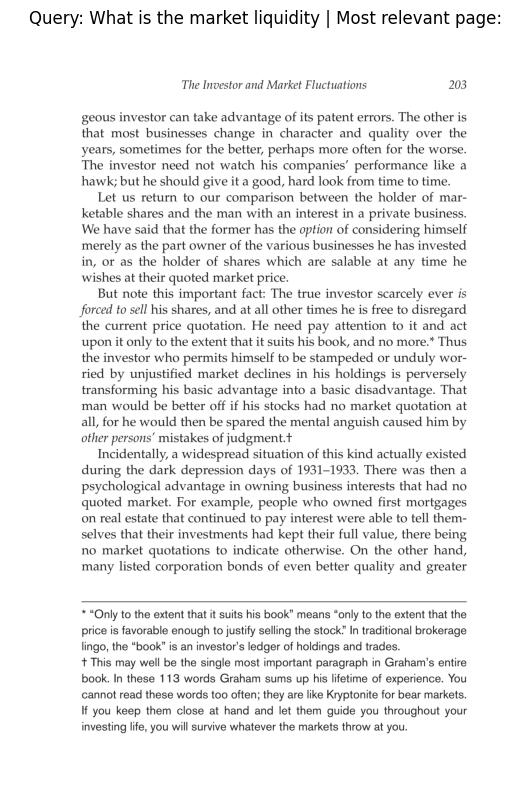

In [ ]:
# now lets visualize the paragraph

import fitz

pdf_path = "The Intelligent Investor - The Definitive Book On Value Investing.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(203+13) # page numbers of our pdf starts 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# save imag
img.save("ouput_file_name.png")
doc.close()

# convert pix map to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape(img.h, img.w, img.n)

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.axis('off')
plt.title(f"Query: {query} | Most relevant page:")
plt.show()

In [ ]:
from timeit import default_timer as timer
def retrieval_relevant_resources(query: str,
                                 embeddings: torch.tensor,
                                 model: SentenceTransformer = embedding_model,
                                 n_resources_to_return: int = 5,
                                 print_time: bool = True):
  """
  Embeds the queary with model and return the top k scores and indices from the embeddings.

  """

  # Embed the query
  query_embedding = model.encode(query, convert_to_tensor=True)

  # Get dot product scores
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time= timer()
  if print_time:
    print(f"[INFO] Dot product time: {end_time - start_time:.4f} seconds")

  scores, indices = torch.topk(dot_scores, k=n_resources_to_return)

  return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int = 5):
  """
  FInds relevant passages given a query and prints them out alog with scores.
  """

  scores, indices = retrieval_relevant_resources(query, embeddings, n_resources_to_return=n_resources_to_return)
  for score, idx in zip(scores, indices):
    print(f"Score: {score:.4f}")
    print(f"Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"], )
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

In [ ]:
query = "second-grade bonds and preferred stocks"

print_top_results_and_scores(query, embeddings)

[INFO] Dot product time: 0.0001 seconds
Score: 0.7405
Text:
acknowledged possibility of a loss of principal in exchange for a mere 1 or 2%
of additional yearly income. If you are willing to assume some risk you should
be certain that you can realize a really substantial gain in principal value if
things go well. Hence a second-grade 5.5 or 6% bond selling at par is almost
always a bad purchase. The same issue at 70 might make more sense—and if you are
patient you will probably be able to buy it at that level. Second-grade bonds
and preferred stocks possess two contra- dictory attributes which the
intelligent investor must bear clearly in mind. Nearly all suffer severe sinking
spells in bad markets. On the other hand, a large proportion recover their
position when favorable conditions return, and these ultimately “work out all
right.”This is true even of (cumulative) preferred stocks that fail to pay
dividends for many years. There were a number of such issues in the early 1940s,
as a c

In [ ]:
!pip install BitsandBytes
!pip install accelerate


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig



qunatization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
    )

model_name = "google/gemma-2b-it"

# temparature value
temperature = 0.3

# attention config
attn_implementation = "sdpa" # Scaler dot produt attention.

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# model
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path = model_name,
    torch_dtype = torch.float16,
    quantization_config = qunatization_config,
    low_cpu_mem_usage = False,
    attn_implementation = attn_implementation,
)


model

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
    

In [ ]:
query = "What is the intelligent investor?"

dilogue_template = [
    {
        "role": "user",
        "content": query
    }
]

# generate the prompt
prompt = tokenizer.apply_chat_template(conversation=dilogue_template, tokenize=False, add_generation_prompt=True)

# print the prompt
print(f"Prompt: {prompt}")

Prompt: <bos><start_of_turn>user
What is the intelligent investor?<end_of_turn>
<start_of_turn>model



In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print("input_ids \n")
print(input_ids)

outputs = model.generate(**input_ids, max_new_tokens = 256)

print("Outputs \n")
print(outputs)

input_ids 

{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573,  25309,
          38737, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
Outputs 

tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573,  25309,
          38737, 235336,    107,    108,    106,   2516,    108,    688,   1969,
          25309,  38737,    688,    603,    671,   3811,   1064,  27425,  31098,
            578,  11319,  14869,    577,  46511,   1024,   6895,   8753,   2183,
          83730,   5685, 235265,   2365,  92628,  15535,   4084, 235269,   3679,
         235269,    578,   5820, 235290,   6576,   4530, 235290,  14577,    577,
           1501,  15335,   9245,  16358, 235265,    109,    688,   2469,  10314,
            576,  25309,  19195,  66058,    109, 235287,   5231, 124149,    578,
          33661,  66058,   2365,  23382,    611,

In [ ]:
outputs_decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(outputs_decoded)

user
What is the intelligent investor?
model
**An intelligent investor** is an individual who actively seeks and implements strategies to maximize their financial returns while minimizing risk. They prioritize objective analysis, research, and evidence-based decision-making to make informed investment choices.

**Key characteristics of intelligent investors:**

* **Rational and analytical:** They rely on logic, reason, and data to evaluate investment opportunities and make sound financial decisions.
* **Risk-averse:** They prioritize minimizing potential losses and avoid taking unnecessary risks that could potentially erode their capital.
* **Long-term horizon:** Intelligent investors focus on the long term and have a patient investment horizon, holding investments for extended periods.
* **Diversified portfolio:** They spread their investments across different asset classes to mitigate risk and maximize potential returns.
* **Continuous learning:** Intelligent investors are lifelong l

In [ ]:
def prompt_formmater(query: str, context_items: list[dict]) -> str:
   context = "-" + "\n -".join([item["sentence_chunk"] for item in context_items])

   base_prompt = """Please use the following context to get idea of what is the context about and try to answer the question: \n\n
   query:
   {query}
   context:
   {context}
   """


   base_prompt = base_prompt.format(query=query, context=context)
   dialogue_template = [
       {"role": "user",
        "content": base_prompt}
   ]

   # Apply the chat template
   prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
   return prompt

query = "What is the intelligent investor?"
scores, indices = retrieval_relevant_resources(query, embeddings)

context_items = [pages_and_chunks[i] for i in indices]
prompt = prompt_formmater(query, context_items)
print(prompt)

[INFO] Dot product time: 0.0001 seconds
<bos><start_of_turn>user
Please use the following context to get idea of what is the context about and try to answer the question: 


   query:
   What is the intelligent investor?
   context:
   -THE INTELLIGENT INVESTOR A B O O K O F P R A C T I C A L C O U N S E L REVISED EDITION B E NJAM I N G RAHAM Updated with New Commentary by Jason Zweig
 -Commentary on the Introduction 13 Graham will show you how to manage it—and how to get your fears under control. A R E Y O U A N I N T E L L I G E N T I N V E S T O R ?Now let’s answer a vitally important question. What exactly does Gra- ham mean by an “intelligent” investor?Back in the first edition of this book, Graham defines the term—and he makes it clear that this kind of intelligence has nothing to do with IQ or SAT scores. It simply means being patient, disciplined, and eager to learn; you must also be able to harness your emotions and think for yourself. This kind of intelligence, explains Graha

In [ ]:
def ask_me(query: str,
           temperature: float = 0.5,
           max_new_token: int = 256,
           format_answer = True,
           return_answer_only = True):
  scores, indices = retrieval_relevant_resources(query, embeddings)

    # create the context item
  context_items = [pages_and_chunks[i] for i in indices]

  # Add score to context item
  for i, item in enumerate(context_items):
    item["score"] = scores[i].cpu()

  prompt = prompt_formmater(query, context_items)

  input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

  outputs = model.generate(**input_ids, max_new_tokens = max_new_token, temperature = temperature, do_sample=True)

  outputs_decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)


  return outputs_decoded

query = "What is foreign policy"
final_ans = ask_me(query)
print(f"Final output: \n {final_ans.replace(prompt, '')}")

[INFO] Dot product time: 0.0001 seconds
Final output: 
 user
Please use the following context to get idea of what is the context about and try to answer the question: 


   query:
   What is foreign policy
   context:
   -Years ago an argument of sorts was made for the purchase of foreign bonds here on the grounds that a rich creditor nation such as ours was under moral obligation to lend abroad. Time, which brings so many revenges, now finds us dealing with an intractable balance-of-payments problem of our own, part of which is ascrib- able to the large-scale purchase of foreign bonds by American investors seeking a small advantage in yield. For many years past we have questioned the inherent attractiveness of such invest- ments from the standpoint of the buyer; perhaps we should add now that the latter would benefit both his country and himself if he declined these opportunities.138 The Intelligent Investor
 -Foreign Government Bonds All investors with even small experience know that